In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def change_bool(df):
    df = df.replace({False: 0, True: 1})
    return df

In [3]:
def change_dn(df):
    df = df.replace({'Day': 0, 'Night': 1})
    return df

In [4]:
df = pd.read_csv('ohe_data.csv')

In [5]:
df.set_index('Unnamed: 0',inplace=True)

In [6]:
X = df[['Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Sunrise_Sunset','wc_clouds','wc_dust','wc_fair','wc_fog','wc_ice','wc_rain','wc_snow','wc_thunder','wc_wind','st_interstate','st_highway','st_other','State_AL','State_AR','State_AZ','State_CA','State_CO','State_CT','State_DC','State_DE','State_FL','State_GA','State_IA','State_ID','State_IL','State_IN','State_KS','State_KY','State_LA','State_MA','State_MD','State_ME','State_MI','State_MN','State_MO','State_MS','State_MT','State_NC','State_ND','State_NE','State_NH','State_NJ','State_NM','State_NV','State_NY','State_OH','State_OK','State_OR','State_PA','State_RI','State_SC','State_SD','State_TN','State_TX','State_UT','State_VA','State_VT','State_WA','State_WI','State_WV','State_WY','Side_L','Side_R','Timezone_US/Central','Timezone_US/Eastern','Timezone_US/Mountain','Timezone_US/Pacific','year_2016','year_2017','year_2018','year_2019','year_2020','year_2021','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']]

In [7]:
X = change_dn(change_bool(X))

In [8]:
y = df['Severity']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
y.value_counts(normalize=True)[0]

0.9000648102378206

In [11]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=0, max_iter=10_000 #, class_weight='balanced'
                              ))
])

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=10000, random_state=0))])

In [13]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9064828317516052, 0.9061152991594448)

In [14]:
y_pred = pipe.predict(X)

In [15]:
confusion_matrix(y, y_pred,normalize='true')

array([[0.97762601, 0.02237399],
       [0.73518657, 0.26481343]])

<AxesSubplot:>

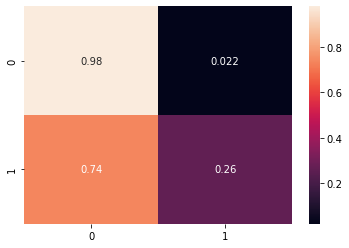

In [16]:
sns.heatmap(confusion_matrix(y, y_pred,normalize='true'), annot=True)

#####  74% of servere accidents were predicted as not servere in our model.

### Change Threshold

In [17]:
y_pred = (pipe.predict_proba(X)[:,1] >= 0.4).astype(bool)

In [18]:
confusion_matrix(y, y_pred,normalize='true')

array([[0.95918388, 0.04081612],
       [0.60311511, 0.39688489]])

<AxesSubplot:>

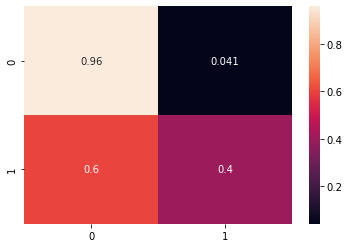

In [19]:
sns.heatmap(confusion_matrix(y, y_pred,normalize='true'), annot=True)

##### Changing the threshold on this initial model does not remedy the amount of false negatives.

#### Different Samling methods were tried next to fix the issues of imbalanced data.

### OVER SAMPLE

In [53]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=0, max_iter=10_000,C=10))
])

In [54]:
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X, y)

##### Baseline for over-sampling is .67

In [55]:
y_over.value_counts(normalize=True)

0    0.666667
1    0.333333
Name: Severity, dtype: float64

In [56]:
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, random_state=42)

In [57]:
pipe.fit(X_over_train,y_over_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=10, max_iter=10000, random_state=0))])

In [58]:
pipe.score(X_over_train,y_over_train),pipe.score(X_over_test,y_over_test)

(0.8305000348956584, 0.8302541994107157)

In [59]:
y_pred = pipe.predict(X)

In [60]:
confusion_matrix(y, y_pred,normalize='true')

array([[0.88491255, 0.11508745],
       [0.27799639, 0.72200361]])

<AxesSubplot:>

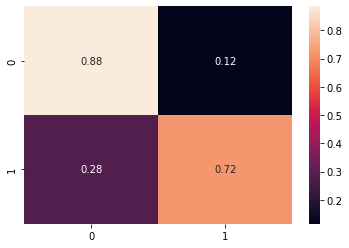

In [62]:
sns.heatmap(confusion_matrix(y, y_pred,normalize='true'), annot=True)

### UNDER SAMPLE

In [29]:
rus = RandomUnderSampler(random_state=0, replacement=True)
X_under, y_under = rus.fit_resample(X, y)

In [30]:
y_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: Severity, dtype: float64

In [31]:
y_under.shape

(545856,)

In [32]:
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, random_state=42)

In [33]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=0, max_iter=10_000,C=10))
])

In [34]:
pipe.fit(X_under_train,y_under_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=10, max_iter=10000, random_state=0))])

In [35]:
pipe.score(X_under_train,y_under_train),pipe.score(X_under_test,y_under_test)

(0.8215182514558174, 0.8225172939383281)

In [36]:
pipe.score(X,y)

0.8157459585141246

In [37]:
y_pred = pipe.predict(X)

In [38]:
confusion_matrix(y, y_pred,normalize='true')

array([[0.81422728, 0.18577272],
       [0.17057612, 0.82942388]])

<AxesSubplot:>

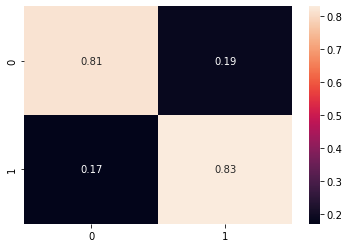

In [39]:
sns.heatmap(confusion_matrix(y, y_pred,normalize='true'), annot=True)